# Exercise 1: time-advancing scheme and neural networks

Exercise on the implementation of Neural ODEs. 

Author: Stefano Pagani <stefano.pagani@polimi.it>.

Date: 2024

Course: Mathematical and numerical foundations of scientific machine learning.




Let us consider the Lorenz system of differential equations:

$
\dot{x} = \sigma (y-x) \\
\dot{y} = x (\rho-z) - y \\
\dot{z} = x y - \beta z
$

with parameters $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

The goal of this exercise is to implement a feed-forward neural network that learns the right-hand side of a dynamical system, which allows to approximate the dynamics of the state.

Complete the notebook accordingly.

In [1]:

# imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K



2024-01-31 14:51:27.829097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 14:51:27.963736: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 14:51:28.588344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 14:51:28.588485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 14:51:28.716432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:


rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [9, 9]

## Simulate the Lorenz System for various initial conditions

dt = 0.01
T = 1.0
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

# Selected proportion of training and validation data
n_samples = 10
n_valid = 5

# Allocate arrays for NN input and ouputs
nn_input = np.zeros((n_samples*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

nn_input_val = np.zeros((n_valid*(len(t)-1),3))
nn_output_val = np.zeros_like(nn_input_val)

nn_pred = np.zeros_like(nn_input_val)

# Define reference dynamics function
def lorenz_deriv(t0, x_y_z, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = 1.5 + 3.0 * np.random.random((n_samples, 3))
x0_val = 1.5 + 3.0 * np.random.random((n_valid, 3))

# Get full reference solution
x_t = np.asarray([integrate.solve_ivp(lorenz_deriv, t_span=(0,T), y0=x0_j, t_eval=t).y for x0_j in x0])

# Get "valid" reference solution (training data)
x_t_val = np.asarray([integrate.solve_ivp(lorenz_deriv, (0,T), y0=x0_j, t_eval=t).y for x0_j in x0_val])



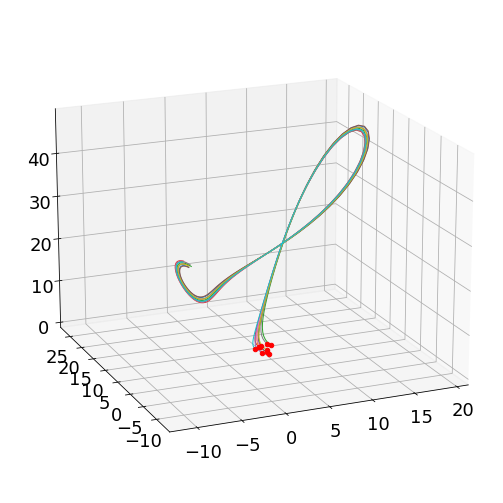

In [3]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

# Training data allocation
for j in range(n_samples):

    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:,:-1].T
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:,1:].T

    x, y, z = x_t[j,:,:]
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

ax.view_init(18, -113)
plt.show()

# Test data allocation
for j in range(n_valid):
    nn_input_val[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t_val[j,:,:-1].T
    nn_output_val[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t_val[j,:,1:].T



In [6]:
# Convert Numpy array to Tensor

X_train = tf.convert_to_tensor(x_t[:,:,:-1],dtype=tf.float64)
Y_train = tf.convert_to_tensor(x_t[:,:,1:],dtype=tf.float64)

X_valid = tf.convert_to_tensor(x_t_val[:,:,:-1],dtype=tf.float64)
Y_valid = tf.convert_to_tensor(x_t_val[:,:,1:],dtype=tf.float64)

Y_pred = tf.convert_to_tensor(nn_pred,dtype=tf.float64)


In [5]:
# Loss function Computation
def loss(X_train,Y_train):

    # Single time step loss
    for k in range(100):
        if k==0:
            Y_pred = tf.expand_dims(Updatemodel(X_train[:,:,0]), 2)
        else:
            Y_pred = tf.concat( [Y_pred, tf.expand_dims(Updatemodel(X_train[:,:,k]),2) ], 2 )

    # Compute overall cost 
    mse_loss = tf.reduce_mean(tf.pow(Y_pred-Y_train,2))

    return mse_loss

# Neural network weight gradients
@tf.function
def grad(model,X_train,Y_train):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(X_train,Y_train)
        grads = tape.gradient(loss_value,model.trainable_variables)
    return loss_value, grads


Task: Compare the following models:

  1. $\bf{x}^{(k+1)} = \mathcal{NN}(\bf{x}^{(k)}; \bf{W})  \Rightarrow $ The NN directly learns to approximate the solution flow field
  2. $\bf{x}^{(k+1)} = \bf{x}^{(k)} + \Delta t \mathcal{NN}(\bf{x}^{(k)}; \bf{W}) \Rightarrow $ The NN learns the ODE dynamics generating the solution flow field 


In [4]:

# Construct the NN architecture
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation=None, input_shape=(3,),kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(16, activation='tanh',kernel_initializer="glorot_normal",dtype=tf.float64),
    tf.keras.layers.Dense(3,activation=None,kernel_initializer="glorot_normal",dtype=tf.float64)
])

# Inputs      = tf.keras.Input(shape=(3,))
# Outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

# Construct the Input-Output relation with the NN (may be any relation, in this case: Euler-integrated dynamics)
inputs      = tf.keras.Input(shape=(3,),dtype=tf.float64)
outputs     = inputs[:,0:3] + 0.01*dense(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs) # TODO: check what this function does

# Good idea to speed-up the training: extract random points of the trajectory instead of comparing the entire trajectory with the reference
# Note: this may be a good idea if the state vector is large. Else, the computational gain is small. However, it may have a positive effect 
# on the train too, specifically in avoiding the NN perfectly learning the trajectories (i.e. interpolation) rather than to generalize.




In [9]:
# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

for iter in range(20000):

  # Compute gradients of the I/O function using AD 
  loss_value,grads = grad(Updatemodel,X_train,Y_train)

  # Update neural network weights
  tf_optimizer.apply_gradients(zip(grads,Updatemodel.trainable_variables))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.16f}'.format(loss_value))
    print('loss_valid = {:.16f}'.format(loss(X_valid,Y_valid)))
   

iter =  200
loss = 0.0201077554621093
loss_valid = 0.0256169519171456
iter =  400
loss = 0.0181901279317181
loss_valid = 0.0233536688189415
iter =  600
loss = 0.0169644086818319
loss_valid = 0.0223787370195195
iter =  800
loss = 0.0161408430780260
loss_valid = 0.0214724216145078
iter =  1000
loss = 0.0154485829123113
loss_valid = 0.0205142498080402
iter =  1200
loss = 0.0147110374651361
loss_valid = 0.0196799651913391
iter =  1400
loss = 0.0142205613323842
loss_valid = 0.0190537602960683
iter =  1600
loss = 0.0137934724630893
loss_valid = 0.0185071430205110
iter =  1800
loss = 0.0134241815815313
loss_valid = 0.0181190428567844
iter =  2000
loss = 0.0130779380836755
loss_valid = 0.0177299825980869
iter =  2200
loss = 0.0125668390269992
loss_valid = 0.0171319158120927
iter =  2400
loss = 0.0122147466442754
loss_valid = 0.0167467709413764
iter =  2600
loss = 0.0118664820015963
loss_valid = 0.0164352768008357
iter =  2800
loss = 0.0114530064764516
loss_valid = 0.0159301288257959
iter =  30

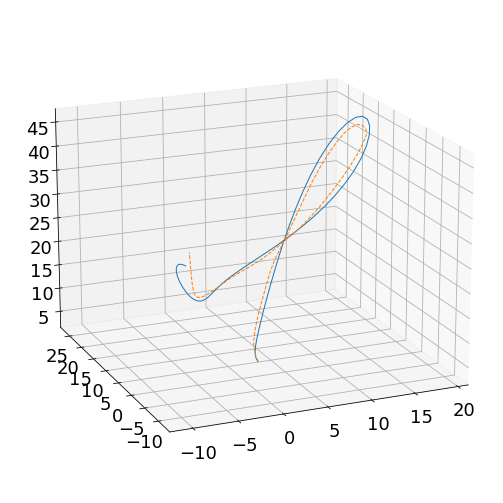

In [8]:
## NN prediction on the test set
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

for k in range(100):
    if k==0:
        Y_plot = tf.expand_dims(Updatemodel(X_valid[:,:,0]),2)
    else:
        Y_plot = tf.concat( [Y_plot, tf.expand_dims(Updatemodel(Y_plot[:,:,-1]),2) ], 2 )

j=1

x = Y_valid.numpy()[j,0,:]
y = Y_valid.numpy()[j,1,:]
z = Y_valid.numpy()[j,2,:]
ax.plot(x, y, z,linewidth=1)
x = Y_plot.numpy()[j,0,:]
y = Y_plot.numpy()[j,1,:]
z = Y_plot.numpy()[j,2,:]
ax.plot(x, y, z,'--',linewidth=1)
    
ax.view_init(18, -113)
plt.show()




Task: implement a custum loss to perform a further training of the neural network. 

In [ ]:

# Loss function Definition (Custom)
def loss_erroIntegral(X_train,Y_train):

    # Single time step loss
    for k in range(100):
        if k==0:
            Y_pred = tf.expand_dims(Updatemodel(X_train[:,:,0]), 2)
        else:
            Y_pred = tf.concat( [Y_pred, tf.expand_dims(Updatemodel(X_train[:,:,k]),2) ], 2 )

    # Compute overall cost 
    mse_custom = tf.reduce_mean( )

    return mse_custom

# neural network weight gradients
@tf.function
def grad(model,X_train,Y_train):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(X_train,Y_train)
        grads = tape.gradient(loss_value,model.trainable_variables)
    return loss_value, grads


In [ ]:
# Adam optimizer
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.99)

for iter in range(10000):

  # compute gradients using AD
  loss_value,grads = grad(Updatemodel,X_train,Y_train)

  # update neural network weights
  tf_optimizer.apply_gradients(zip(grads,Updatemodel.trainable_variables))

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.16f}'.format(loss_value))
    print('loss_valid = {:.16f}'.format(loss(X_valid,Y_valid)))

In [ ]:
## NN prediction on the test set
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})

for k in range(100):
    if k==0:
        Y_plot = tf.expand_dims(Updatemodel(X_valid[:,:,0]),2)
    else:
        Y_plot = tf.concat( [Y_plot, tf.expand_dims(Updatemodel(Y_plot[:,:,-1]),2) ], 2 )

j=0

x = Y_valid.numpy()[j,0,:]
y = Y_valid.numpy()[j,1,:]
z = Y_valid.numpy()[j,2,:]
ax.plot(x, y, z,linewidth=1)
x = Y_plot.numpy()[j,0,:]
y = Y_plot.numpy()[j,1,:]
z = Y_plot.numpy()[j,2,:]
ax.plot(x, y, z,'--',linewidth=1)
    
ax.view_init(18, -113)
plt.show()

Task: train using different configurations (and optmization settings)